# FBI Hate Crime Statistics (2016)

> The FBI’s UCR Program is a nationwide, cooperative statistical effort of more than 18,000 city, university and college, county, state, tribal, and federal law enforcement agencies eligible to voluntarily report data on crimes brought to their attention. Since 1930, the FBI has administered the UCR Program and has continued to assess and monitor the nature and type of crime in the nation. (Source: <https://ucr.fbi.gov/hate-crime/2016/resource-pages/aboutucrmain>)

The _Hate Crime Statistics Program_ is one of four subprograms of the The FBI's Uniform Crime Reporting (UCR) program and provides annual data “about crimes that manifest evidence of prejudice based on race, religion, sexual orientation, or ethnicity” (https://ucr.fbi.gov/hate-crime/2016/resource-pages/aboutucrmain).

The goal of this study is to use these data to investigate:
* What are the most frequently reported motivations for hate crimes in the U.S.?
* Who or what are the most frequently reported victims of hate crimes in the U.S.?
* How does the number of reported hate crimes in each state correlate with population density?
* How does the fraction of reported race motivated crimes in each state correlate with the fraction of 'white' population?
* How are the reported hate crimes distributed across states?

### Data sources
Copies of the input data files used in this notebook are stored in the ```data/``` subdirectory.

The 2016 _Hate Crime Statistics_ data are available from https://ucr.fbi.gov/hate-crime/2016/resource-pages/download-files and include a variety of tables. The ones used for this study are:
    
 * Table 11: Incidents per offense type and state <br /> (__File:__ ```data/fbi/Table_11_Offenses_Offense_Type_by_Participating_State_2016.xls```)<br /> <br />
 
 * Table 13: Incidents per bias motivation and state <br /> (__File:__ ```data/fbi/Table_13_Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_and_Agency_2016.xls```)

Data from the Census Bureau's Population Estimates Program (PEP, https://www.census.gov/programs-surveys/popest.html) are available from https://factfinder.census.gov/. For this study, we use
 
 * A spreadsheet with U.S. population estimates for July 1, 2016 per state for different racial groups. Counts include both hispanic and non-hispanic origin, and both male and female sex. Source: U.S. Census Bureau, Population Division (Release Date: June 2017). <br />(__File:__ ```data/census/PEP_2016_PEPSR6H.xls```) <br /> <br />
 
 * A spreadsheet with U.S. population density estimates and area per state from the 2010 Census. Source: U.S. Census Bureau, 2010 Census. <br />(__File:__ ```data/census/DEC_10_SF1_GCTPH1.US01PR.xls```)


### Importing libraries
Importing the libraries that this notebook is using:

In [1]:
# import libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from IPython.display import HTML, display

import us
import os

%matplotlib inline

# Reading and cleaning the data used in this notebook

### Reading and cleaning the 2016 FBI Hate Crime Statistics data

Read Excel tables into dataframes and clean data via function defined in __read_fbi_tables.py__

In [2]:
from read_fbi_tables import read_tables as read_fbi

# get dataframe with data from FBI Hate Crime Statistics
df_fbi = read_fbi()

Summary of statistics in FBI Hate Crime Statistics data summed over all U.S. states:

In [3]:
# getting an overview of our data
print("The imported FBI data has {0} rows and {1} columns.\n".format(df_fbi.shape[0], df_fbi.shape[1]))

# checking for missing values
print("Are there missing values? {} .\n".format(df_fbi.isnull().any().any()))

# count total records in each categrory/type
print( df_fbi.sum() )

The imported FBI data has 50 rows and 21 columns.

Are there missing values? True .

Category                       Type                          
Crimes total                   Crimes total                      7321.0
Crimes against persons         Murder                               9.0
                               Rape                                24.0
                               Aggravated assault                 873.0
                               Simple assault                    1687.0
                               Intimidation                      2109.0
                               Other                               18.0
Crimes against property        Robbery                            134.0
                               Burglary                           123.0
                               Larceny, theft                     231.0
                               Motor vehicle theft                 20.0
                               Arson                         

### Reading and cleaning U.S. Census data for population count per state (2016)

We read U.S. census data on 2016 population estimates (including information on race) and perform a few cleanup steps to remove empty columns (which end up in the dataframe as columns with 'NaN' values) and rename the index and names of some columns for easier readibility.

In [4]:
# Read Excel spreadsheet into dataframe.
df_census_pop = pd.read_excel("data/census/PEP_2016_PEPSR6H.xls", header=[0,1], index_col=None, skiprows=2, skip_footer=7)

# Drop columns with 'NaN'.
df_census_pop.dropna( axis=1, inplace=True )

# Update names of column levels.
df_census_pop.columns.names = ['Category','Data']

# Rename index.
df_census_pop.index.name = ['State']

# Rename first-level column labels.
df_census_pop = df_census_pop.rename( index = str, columns = { "Total":    "Population Total",
                                                               "Race Alone":   "Population Race Alone",
                                                               "Two or More Races":   "Population Two or More Races" })

# Rename second-level column labels.
df_census_pop = df_census_pop.rename( index = str, columns = { "Unnamed: 2_level_1":    "Population Total",
                                                               "Unnamed: 10_level_1":   "Population Two or More Races" } )

# Convert datatypes to float
for column in df_census_pop:
    df_census_pop[column] = df_census_pop[column].str.replace(",","").astype(float)

### Reading and cleaning 2010 U.S. Census data for population density and area per state

We read Census data from an Excel spreadsheet that contains U.S. population density estimates and area per state from the 2010 Census. We perform a few cleanup steps to remove empty columns (which end up in the dataframe as columns with 'NaN' values) and rename the index and names of some columns for easier readibility.

In [5]:
# Read Excel spreadsheet into dataframe.
df_census_geo = pd.read_excel("data/census/DEC_10_SF1_GCTPH1.US01PR.xls", header=[0,1], index_col=None, skiprows=4, skip_footer=67)

# Drop columns with 'NaN'.
df_census_geo.dropna( axis=1, inplace=True )

# Update names of column levels.
df_census_geo.columns.names = ['Category','Data']

# Rename index.
df_census_geo.index.name = ['State']

# Drop columns for Population (2010) and Density based on these population numbers.
df_census_geo.drop( ["Population", "Housing units", "Density per square mile of land area"], level=0, axis=1, inplace=True )

# Drop row for 'United States' total area.
df_census_geo.drop( "United States", axis=0, inplace=True )

# Rename firstlevel column labels.
df_census_geo = df_census_geo.rename( index = str, columns = { "Area in square miles":    "Area" } )

# This dataframe has trailing whitespaces in the index. Remove them.
df_census_geo.index = df_census_geo.index.str.strip()

# Convert datatypes to float
for column in df_census_geo:
    df_census_geo[column] = df_census_geo[column].str.replace(",","").astype(float)

### Merging all input dataframes into a single dataframe

__Merge__ the two Census dataframes into one df_census dataframe.

In [6]:
# Merge dataframes from individual tables into one dataframe. Use index (i.e. 'State') as key for merging.                                                                  
df_census = pd.merge( df_census_pop , df_census_geo , left_index=True, right_index=True )

In [7]:
# getting an overview of our data
print("The imported Census data has {0} rows and {1} columns.\n".format(df_census.shape[0], df_census.shape[1]))

# checking for missing values
print("Are there missing values? {} .\n".format(df_census.isnull().any().any()))

The imported Census data has 51 rows and 10 columns.

Are there missing values? False .



__Merge__ FBI and Census dataframes into one dataframe. Working with only a single dataframe will make data exploration easier.

In [8]:
# Merge dataframes from individual tables into one dataframe. Use index (i.e. 'State') as key for merging.                                                                  
df_states = pd.merge( df_fbi , df_census , left_index=True, right_index=True )

__Add__ a few columns to the dataframe that are calculated from existing columns and make the data exploration and visualization easier in the next part of this notebook.

In [9]:
# create mapping between state abbreviation (used by json mapping file) and name (used by FBI tables)
state_name_abbr = us.states.mapping('name','abbr')

# Add state name abbreviations to dataframe
df_states['State_Abbr'] = [state_name_abbr[name] for name in df_states.index]

# Add population density to dataframe
df_states['Population density'] = df_states[('Population Total','Population Total')] / df_states[('Area','Land area')]

# Add fraction of 'white' peolpe in state populations to dataframe
df_states['Population white fraction'] = df_states[('Population Race Alone','White')] / df_states[('Population Total','Population Total')]

# Add fraction of 'Race, ethnicity, ancestry' motivated hate crimes to dataframe
df_states['Fraction race motivated crimes'] = df_states[('Incidents per bias motivation','Race, ethnicity, ancestry')] / df_states[('Crimes total','Crimes total')]

# Add ratio of crimes per 1 million population to dataframe
df_states['Crimes per 1M population'] = 1e6 * df_states[('Crimes total','Crimes total')] / df_states[('Population Total','Population Total')]

Printing some summary statistics of the merged dataframe:

In [10]:
# getting an overview of our data
print("The imported data has {0} rows and {1} columns.\n".format(df_states.shape[0], df_states.shape[1]))

# checking for missing values
print("Are there missing values? {} .\n".format(df_states.isnull().any().any()))

The imported data has 50 rows and 36 columns.

Are there missing values? True .



We now have a data set with information about the 2016 FBI hate crime statistics, population, and area for the states of the U.S. Next, we will explore some features of these data and look for correlations.

# Visualizing the data
Global seaborn settings:

In [11]:
sns.set(style="whitegrid")

Define a color palette based on the Tableau Color Blind 10 palette (see https://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues).

In [12]:
# define colors for matplotlib
colors_colorblind10 = [ (0/256.,107/256.,164/256.),
                        (255/256.,128/256.,14/256.),
                        (171/256.,171/256.,171/256.),
                        (89/256.,89/256.,89/256.),
                        (95/256.,158/256.,209/256.),
                        (200/256.,82/256.,0/256.)]

#### Which motivations are indicated most frequently for the reported hate crimes in the U.S.?
To address this question, we create a bar chart that illustrates the relative contribution of different bias motivations to the total number of reported crimes in 2016.

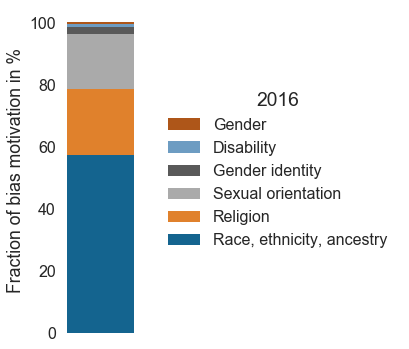

In [13]:
# sum crimes over states
motivation = df_fbi['Incidents per bias motivation'].sum()

# sort values- most frequently reported to least
motivation.sort_values( inplace=True, ascending=False )

# normalize bias motivations
total_crimes = motivation.sum()
motivation_norm = 100. * motivation / total_crimes

# create cumulative sum over entries and reverse order to allow for plotting a stacked bar chart,
# i.e. largest value needs to be plotted as the first bar with the others on top by decreasing height
motivation_norm_sum = motivation_norm.cumsum()
motivation_norm_sum = motivation_norm_sum.reindex(index=motivation_norm_sum.index[::-1])

# Plot bar chart of reported bias motivations.

# Choose plotting context "notebook", “paper”, “talk”, or “poster”:
with sns.plotting_context("poster", font_scale=1.0, rc={"axes.axesbelow": False}):
    
    # Choose white background, Turn off grid.
    sns.set_style("whitegrid", {"axes.grid": False})
    
    # Initialize the matplotlib figure.
    f, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the fractions of bias motivations as individual bars on top of each other.
    coliter=5
    for index, val in motivation_norm_sum.iteritems():
            sns.barplot(y=val, label=index, color=colors_colorblind10[coliter])
            coliter-=1
            
    # Add a legend and informative axis label.
    ax.legend(ncol=1, loc="right", frameon=False, title="2016")
    ax.set(xlim=(0, 2), xlabel="", ylabel="Fraction of bias motivation in %")
    sns.despine(left=True, bottom=True)

    # Show final plot.
    plt.show()

Almost two thirds of the reported crimes are motivated by race, ethnicity, or ancestry of the victim(s). Religion and sexual orientation together make up approximately another third (with about equal shares).

#### Are the reported hate crimes mostly targeting people, property, or society in general?
To address this question, we create a bar chart that illustrates the relative contribution of reported crimes targeting persons, property, and society to the total number of reported crimes.

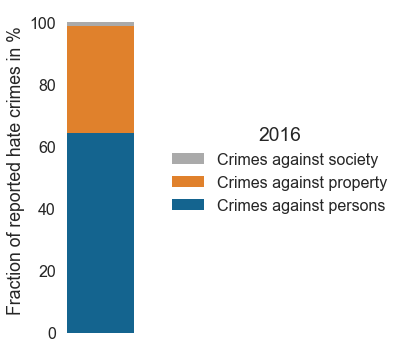

In [14]:
# Count total number of reported crimes in each category:
count_persons = df_fbi['Crimes against persons'].sum().sum()
count_property = df_fbi['Crimes against property'].sum().sum()
count_society = df_fbi['Crimes against society'].sum().sum()

count_total = count_persons + count_property + count_society

# Choose plotting context "notebook", “paper”, “talk”, or “poster”:
with sns.plotting_context("poster", font_scale=1.0, rc={"axes.axesbelow": False}):
    
    # Choose white background, Turn off grid.
    sns.set_style("whitegrid", {"axes.grid": False})
    
    # choose color palette
    #sns.set_color_codes("dark")
    
    # Initialize the matplotlib figure.
    f, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the fractions of hate crime victims.
    sns.barplot(y=100*(count_persons+count_property+count_society)/count_total,
                label="Crimes against society", color=colors_colorblind10[2])

    sns.barplot(y=100*(count_persons+count_property)/count_total,
                label="Crimes against property", color=colors_colorblind10[1])

    sns.barplot(y=100*count_persons/count_total,
                label="Crimes against persons", color=colors_colorblind10[0])

    # Add a legend and informative axis label.
    ax.legend(ncol=1, loc="right", frameon=False, title="2016")
    ax.set(xlim=(0, 2), xlabel="", ylabel="Fraction of reported hate crimes in %")
    sns.despine(left=True, bottom=True)

    # Show final plot.
    plt.show()

About two thirds of the reported hate crimes in the FBI dataset from 2016 target people.

#### Exploring correlations in the data ####

How does the number of reported hate crimes in each state correlate with population density?

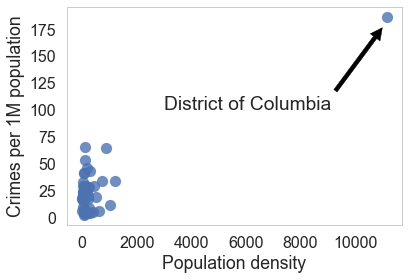

In [15]:
# Correlation plot hate crimes vs population density
#df_states.plot(y=('Crimes per 1M population'), x=('Population density'), kind='scatter')

# Choose plotting context "notebook", “paper”, “talk”, or “poster”:
with sns.plotting_context("poster", font_scale=1.0 ):
    sns.regplot(y=('Crimes per 1M population'), x=('Population density'), data=df_states, fit_reg=False)
    
    # Annotate with text + Arrow
    plt.annotate(
    # Label and coordinate
    'District of Columbia', xy=(11100, 180), xytext=(3000, 100),
 
    # Custom arrow
    arrowprops=dict(facecolor='black', shrink=0.05)
    )

There appears to be one outlier state with notably high population density and number of reported hate crimes per 1 million population:

In [16]:
print("Outlier state: {}".format( df_states[ df_states["Population density"] > 10000].index[0] ) )

Outlier state: District of Columbia


District of Columbia is special among the other U.S. states in this study because it is a densely populated metropolitan area without much surrounding area (https://en.wikipedia.org/wiki/Washington,_D.C.). While there are other densely populated metropolitan areas in the U.S. like New York City (New York, about 27,000 people per square mile; https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population_density), the numbers for those get averaged over their respective states and therefore are expected to have less of a visible effect on this comparison study on the state level. It would be an interesting follow-up study to look at numbers of reported hate crimes in major cities and other densely populated areas in comparison to more rural areas, i.e. do a similar correlation plot but with finer separation of different areas than state lines.

We do the previous correlation plot again, this time excluding District of Columbia:

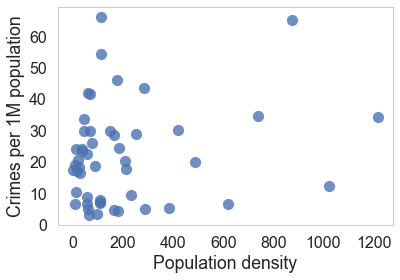

In [17]:
# Create selection of dataframe excluding District of Columbia
df_states_nodc = df_states[ (df_states.index !="District of Columbia") ]

# Correlation plot hate crimes vs population density- excluding District of Columbia
#df_states_nodc.plot(y=('Crimes per person'), x=('Population density'), kind='scatter')

# Choose plotting context "notebook", “paper”, “talk”, or “poster”:
with sns.plotting_context("poster", font_scale=1.0 ):
    sns.regplot(y=('Crimes per 1M population'), x=('Population density'), data=df_states_nodc, fit_reg=False)

There appears to be no strong correlation between the number of reported hate crimes per 1 million population and the population density for the U.S. states (excluding District of Columbia).

What are the correlations between states for:
* Crimes per 1 million population,
* Population density,
* Fraction of crimes motivated by race, ethnicity, ancestry,
* Fraction of 'white' people in the state's population?

These scatterplots again __exclude__ the District of Columbia.

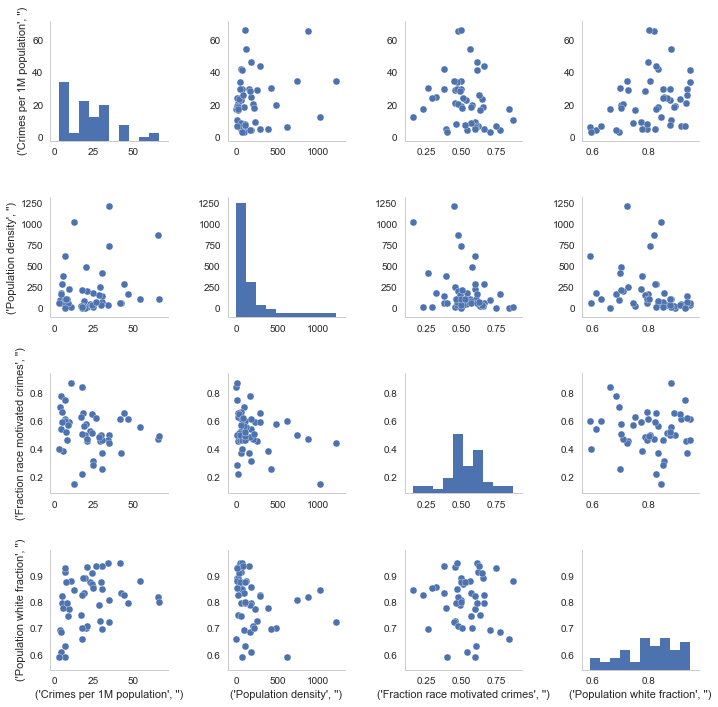

In [18]:
# Choose plotting context "notebook", “paper”, “talk”, or “poster”:
with sns.plotting_context("notebook", font_scale=1.0, rc={"axes.axesbelow": False}):
    sns.pairplot( df_states_nodc[['Crimes per 1M population','Population density','Fraction race motivated crimes','Population white fraction']])

There appear to be no notable correlations between these observables. However, the number of reported hate crimes per one million population varies between 3 and 66 for different states (excluding District of Columbia; see top left histogram in plot above and printout below), so there might be a correlation with other indicators not considered in this study so far.

In [19]:
# print minimum and maximum entry for "Crimes per 1M population" column in dataframe
print("Number of crimes reported per 1 million population varies from {0:.0f} to {1:.0f} between states.".format(df_states_nodc["Crimes per 1M population"].min(), df_states_nodc["Crimes per 1M population"].max()))

Number of crimes reported per 1 million population varies from 3 to 66 between states.


#### How are the reported hate crimes per 1 million population distributed geographically across the states in the U.S.?
Draw a choropleth map of the U.S. with the color coding reflecting the number of reported hate crimes per one million population in each state (excluding District of Columbia). Are there any geographic patterns? To draw the states, we use the Folium package and the json states mapping file from the Folium examples (https://folium.readthedocs.io/).

In [20]:
# use Folium for choropleth map visualization

# import json states mapping file from Folium examples
state_geo = os.path.join('data/folium', 'folium_examples_us-states.json')

# create map
map_states = folium.Map(location=[48, -102], zoom_start=3)

# add choropleth to map
map_states.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_states_nodc,
    columns=['State_Abbr', 'Crimes per 1M population'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Reported hate crimes per 1 million population'
)

folium.LayerControl().add_to(map_states)

map_states

There are regions in the U.S. where neighboring states have the same color on this map. This suggests that the numbers of hate crimes reported per 1 million population relates to common characteristics of these regions beyond the boundaries of individual states. Identifying such underlying relations would need further investigation.

# Next steps

This concludes this study. Some ideas for follow-up questions to investigate are:
* How does the number of reported hate crimes in each state correlate with the Southern Poverty Law Center map of identified hate groups? https://www.splcenter.org/hate-map
* How does the number of reported hate crimes in each state correlate with other indicators, like unemployment rate or overall crime rate?
* How do the numbers of reported hate crimes in major cities and other densely populated areas compare to those for more rural areas?
* The Bureau of Justice reported in a press release on June 29, 2017 a much larger number of hate crimes having occurred in the U.S. every year than is indicated by the FBI data, and that many of these crimes were never reported to the police (https://www.bjs.gov/content/pub/press/hcv0415pr.cfm). This press release bases on The National Crime Victimization Survey (NCVS) data on hate crime victimization from 2004 to 2015. The data is available from the Bureau of Justice page: https://www.bjs.gov/index.cfm?ty=pbdetail&iid=5967. How are the results of this survey correlated with the FBI data? How does the rate of underreporting vary across the individual states of the U.S.?